In [1]:
from DatasetGenerator import *
from helpers import *
from markov_algos import *
from plots import *

import numpy as np
import pandas as pd
from time import time

%load_ext autoreload
%autoreload

# 1. Simple Instances

First of all we test our implementation to make sure that it outputs the desire result for simple instances for which we know the result.

In [2]:
def testing_metropolis(data, betas, lambda_, n_iter):
    n, coords, pop = data.N, data.x, data.v
    
    starting_state = np.zeros(n)
    #starting_state[ pop == np.max(pop)] = 1
    S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False, plot=True)
    
    print('S~:', S_approx)
    print('size of S~:', len(S_approx))
    print('f(S~) = ',f(S_approx, lambda_, data))

We evaluate our algorithm with `lambda`=0. For this simple instance we know that $S^*$ is equal to the whole set of cities, so our implementation should output all the cities.

S~: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
size of S~: 100
f(S~) =  47.755362911469625


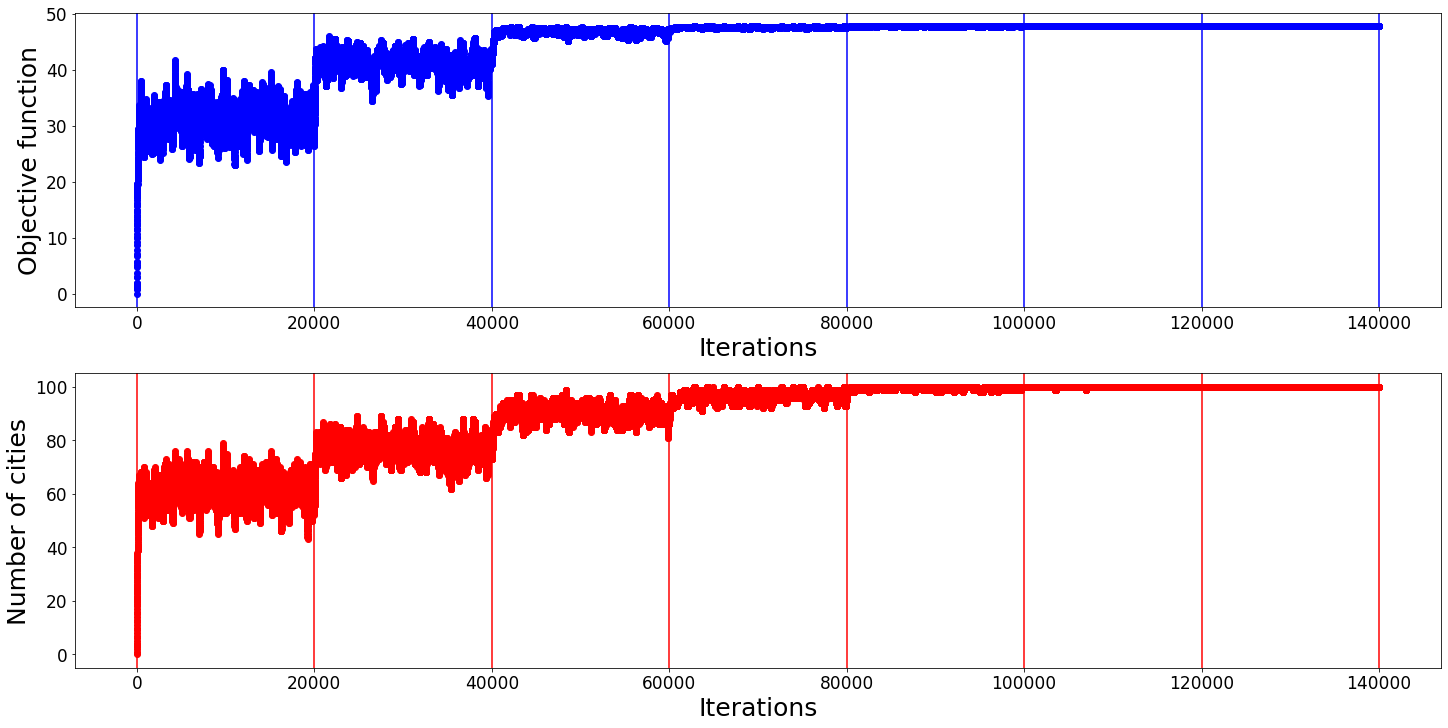

In [3]:
data = G1()  
lambda_ = 0
n_iter = 20000
betas = np.logspace(0, 3, 7)

testing_metropolis(data, betas, lambda_, n_iter)

We evaluate our algorithm on with `lambda`=10000.  We expect the size of $\tilde{S}$ (the approximation of $S^*$) to be small. Furthermore, if it contains only 1 city, we expect it to be the most crowded city.

most crowded city: 43
f(most crowded city) = 0.9998495040121481
S~: [43]
size of S~: 1
f(S~) =  0.9998495040121481


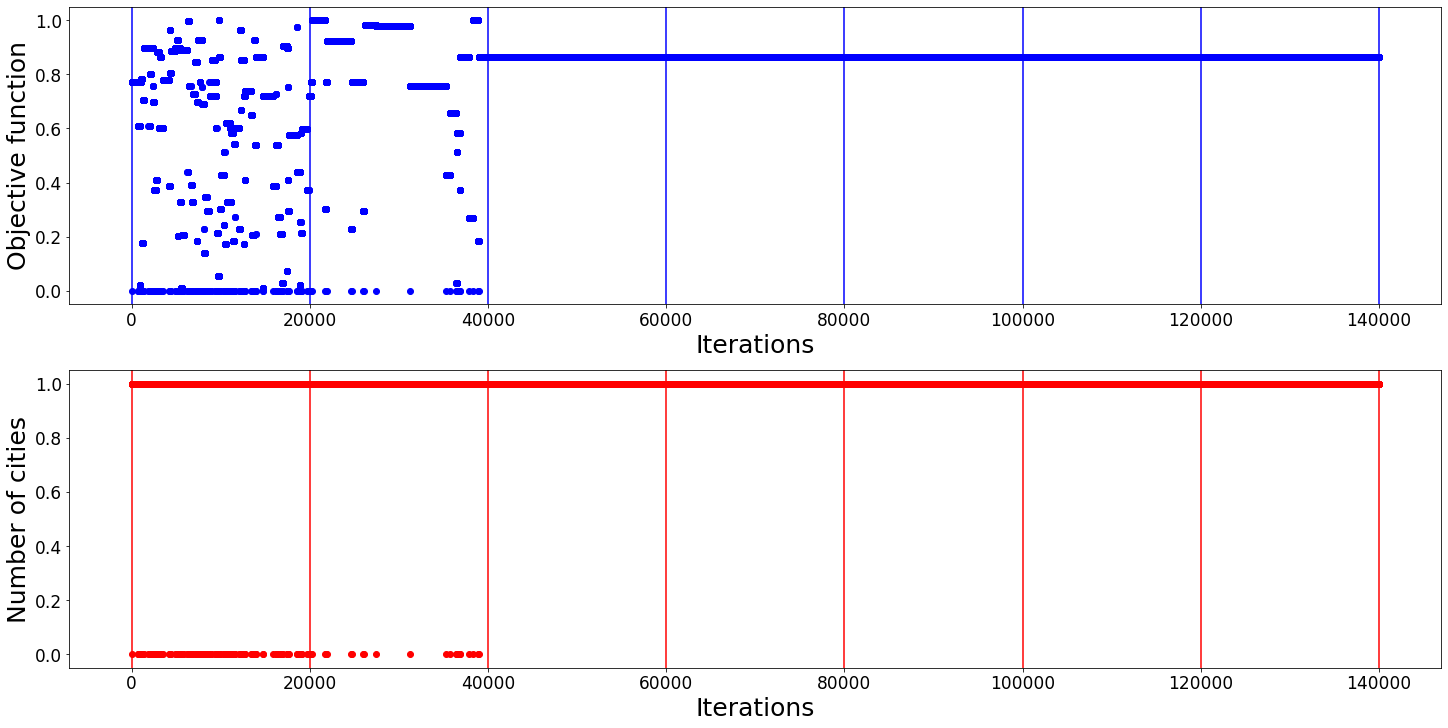

In [4]:
data = G1()  
lambda_ = 10000
n_iter = 20000
betas = np.logspace(0, 3, 7)

most_crowded_city = np.argwhere(data.v == np.max(data.v))[0][0]
print('most crowded city:', most_crowded_city)
print('f(most crowded city) = {}'.format(f([most_crowded_city], lambda_, data)))

testing_metropolis(data, betas, lambda_, n_iter)

# 2. Tuning of hyper-parameters

Once we got a good feedback from the simplest istances we tune the hyper-parameters for more complex problem ($\lambda \approx 1$)

### Evaluation of the best `starting_state`

We compare the perfomances starting at a random state, the state containing only the most crowded city and the state containing all cities.

In [5]:
lambdas = [0.5,1]

n_best_approx = np.zeros([len(lambdas),3])
count_equivalence = np.zeros([len(lambdas),4])

n_istances = 30
for l,lambda_ in enumerate(lambdas):
    for _ in range(n_istances):
        data = G1()  
        n_iter = 10000
        betas = np.logspace(0, 3, 7)
        starting_states = [np.random.randint(low=0, high=2, size=data.N), np.zeros(data.N), np.ones(data.N)]
        starting_states[1][ data.v == np.max(data.v)] = 1
        maxs_f_approx = np.zeros(3)
    
        for i, starting_state in enumerate(starting_states):
            S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False)
            maxs_f_approx[i] = f(S_approx, lambda_, data)
        max_f_approx = max(maxs_f_approx)
        count = 0
        for i, max_f_approx_i in enumerate(maxs_f_approx):
            if max_f_approx_i==max_f_approx:
                n_best_approx[l,i] += 1
                count +=1
        count_equivalence[l,count] +=1

In [6]:
starting_states = ['random', 'crowded_city', 'ones']
for l, lambda_ in enumerate(lambdas):
    print('\n\nFor Lambda = {}'.format(lambda_))
    for i in range(3):
        print('Using starting_state={} we get the best approx max of f {:.1%} of times'.format(starting_states[i],n_best_approx[l,i]/n_istances))
    
    print('The best approximated solution is the same for all the 3 starting_states {:.1%} of times'.format(count_equivalence[l,3]/n_istances) )
    print('The best approximated solution is the same only for 2 starting_states {:.1%} of times'.format(count_equivalence[l,2]/n_istances) )
    print('The best approximated solution is the unique among the three starting_states {:.1%} of times'.format(count_equivalence[l,1]/n_istances) ) 



For Lambda = 0.5
Using starting_state=random we get the best approx max of f 36.7% of times
Using starting_state=crowded_city we get the best approx max of f 60.0% of times
Using starting_state=ones we get the best approx max of f 36.7% of times
The best approximated solution is the same for all the 3 starting_states 0.0% of times
The best approximated solution is the same only for 2 starting_states 33.3% of times
The best approximated solution is the unique among the three starting_states 66.7% of times


For Lambda = 1
Using starting_state=random we get the best approx max of f 20.0% of times
Using starting_state=crowded_city we get the best approx max of f 80.0% of times
Using starting_state=ones we get the best approx max of f 13.3% of times
The best approximated solution is the same for all the 3 starting_states 3.3% of times
The best approximated solution is the same only for 2 starting_states 6.7% of times
The best approximated solution is the unique among the three starting_s

Starting with the most crowded city gives better result than the other starting states.

### Evaluation of the list of $\beta$ to use

We fix the total number of iterations to be `total_n_iter = 1 000 000` and `lambda = 0.5`. Using the generator of instances $\mathcal{G}_1$ we tune the maximum value of $\beta$ (`max_beta`) and the number of  $\beta$ (`nb_beta`).

In [7]:
datas = [G1() for i in range(3)]

lambda_ = 0.5
total_n_iter = 1000000

max_beta = [3, 4, 5] # 10-th power
nb_beta = [5, 7, 10, 13]
n_iter_range = [total_n_iter // b_nb for b_nb in nb_beta]

df = pd.DataFrame(columns=['max beta', 'nb beta', 'avg max obj', 'avg size of S'])

for b_max in max_beta:
    for i, b_nb in enumerate(nb_beta):
        betas = np.logspace(0, b_max, b_nb)
        n_iter = n_iter_range[i]

        avg_obj, avg_size = avg(datas, betas, lambda_, n_iter)
        res = {'max beta':int(b_max), 'nb beta':int(b_nb), 'avg max obj':round(avg_obj,3), 'avg size of S':round(avg_size,1)}
        df = df.append(res, ignore_index=True)

df.iloc[:,:3].to_csv('plots/betas.csv', index=False)
df

,max beta,nb beta,avg max obj,avg size of S
0,3.0,5.0,5.476,64.0
1,3.0,7.0,5.721,65.7
2,3.0,10.0,4.994,62.3
3,3.0,13.0,5.721,65.7
4,4.0,5.0,1.618,33.7
5,4.0,7.0,5.712,65.7
6,4.0,10.0,5.721,65.7
7,4.0,13.0,4.861,62.7
8,5.0,5.0,2.200,36.0
9,5.0,7.0,4.047,69.7


Here we plot the result for the best value of `max_beta`.

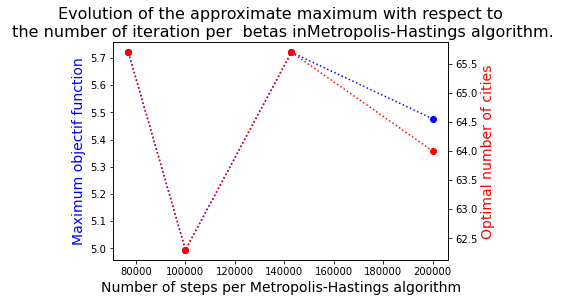

In [8]:
best_obj = max(df.iloc[:,2])
best_max_beta = df[df['avg max obj'] == best_obj].iloc[:,0].tolist()[0]
best_nb_beta = int(df[df['avg max obj'] == best_obj].iloc[:,1].tolist()[0])

obj_range = df[df['max beta'] == best_max_beta].iloc[:,2].tolist()
size_range = df[df['max beta'] == best_max_beta].iloc[:,3].tolist()

fig, ax = plt.subplots()
ax.plot(n_iter_range, obj_range, color='blue', marker='o', ls=':')
ax2 = ax.twinx()
ax2.plot(n_iter_range, size_range, color='red', marker='o', ls=':')

ax.set_title("Evolution of the approximate maximum with respect to"
             + "\n the number of iteration per  betas inMetropolis-Hastings algorithm.", fontsize=16)
ax.set_xlabel("Number of steps per Metropolis-Hastings algorithm", fontsize=14)
ax.set_ylabel("Maximum objectif function", color='blue', fontsize=14)
ax2.set_ylabel("Optimal number of cities", color='red', fontsize=14)
plt.show()

# 3. Understand the evolution of the chain (answers to questions 2 and 3)

In [9]:
# parameters
n_iter = total_n_iter // best_nb_beta
betas = np.logspace(0, best_max_beta, best_nb_beta)

## Ploting the evolution of the Markov chain during the simulated annealing process (with G1, Q2.a)

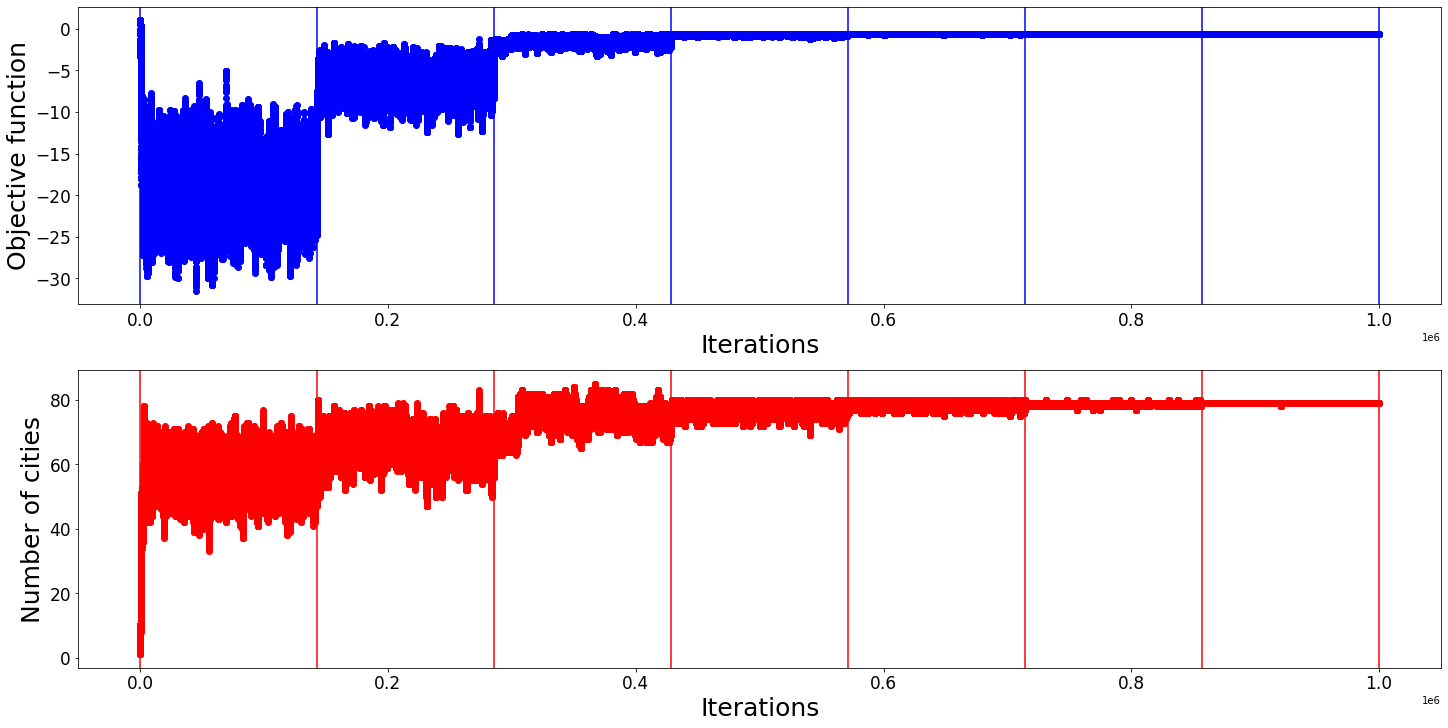

In [10]:
data = G1()
lambda_ = 0.5
starting_state = np.zeros(data.N) 
starting_state[ data.v == np.max(data.v)] = 1

S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False, plot=True)

# Ploting the evolution of the average approximation with respect to lambda  (with G1, Q2.b)

C:\Users\Riccardo\Desktop\1° Semester\Markov Chain and algorithmic applications\markov-chains-COM-516\plots.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


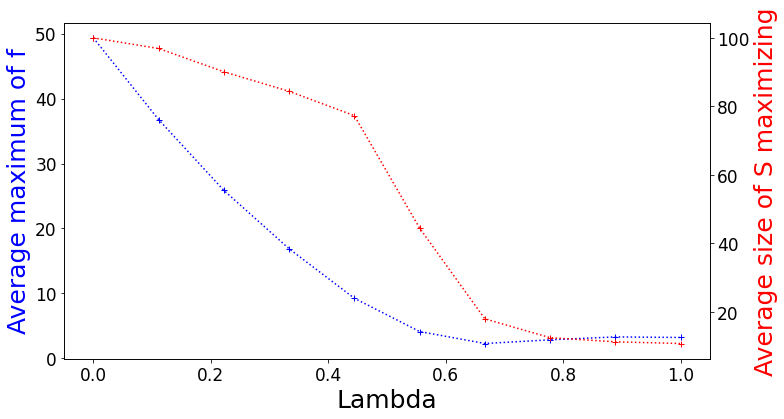

In [11]:
G = G1 
nb_instances = 10
lambdas = np.linspace(0, 1, 10)

plot_avg_lambda(G, lambdas, betas, n_iter, nb_instances, verbose=False)

# Ploting the evolution of the Markov chain during the simulated annealing process (with G2, Q3.a)

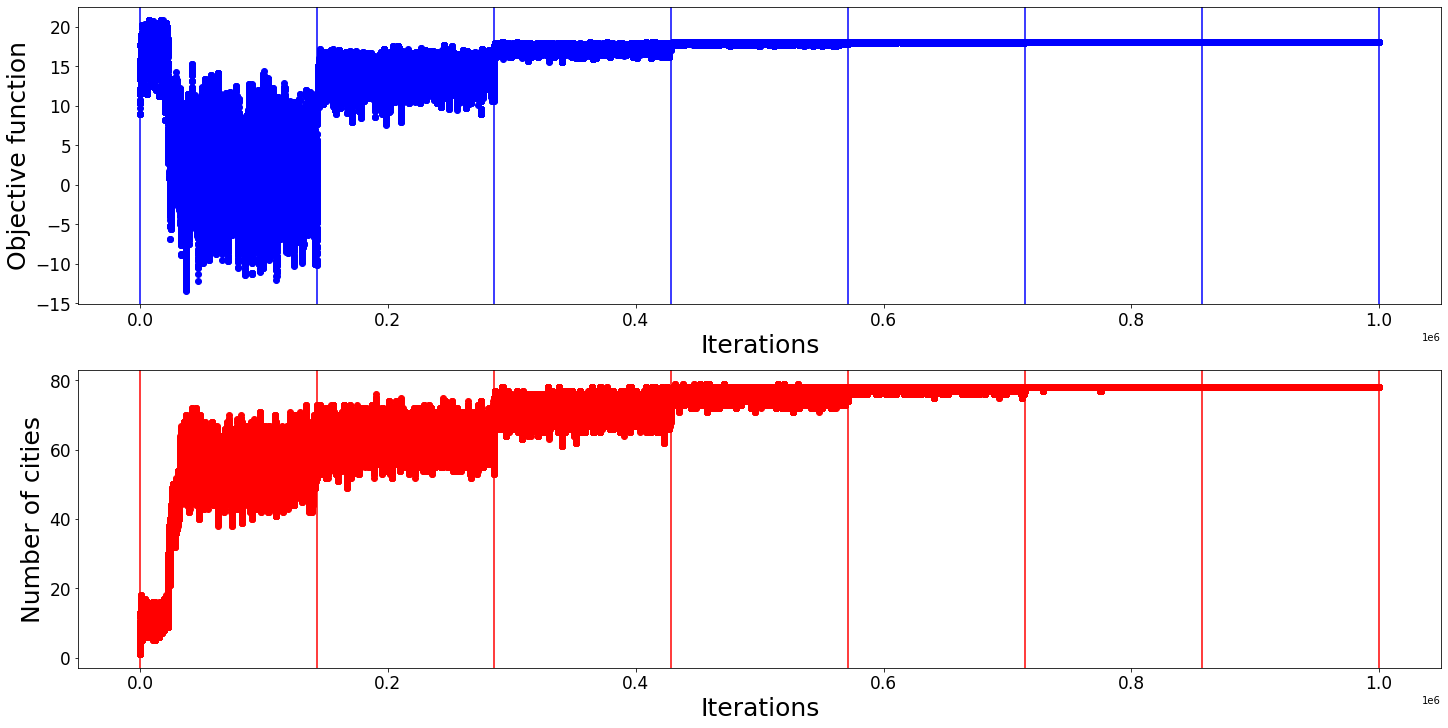

In [12]:
data = G2()
lambda_ = 1
starting_state = np.zeros(data.N) 
starting_state[ data.v == np.max(data.v)] = 1

S_approx = simulated_annealing(starting_state, betas, n_iter, lambda_, data, verbose=False, plot=True)

# Ploting the evolution of the average approximation with respect to lambda  (with G2, Q3.b)

C:\Users\Riccardo\Desktop\1° Semester\Markov Chain and algorithmic applications\markov-chains-COM-516\plots.py:68: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


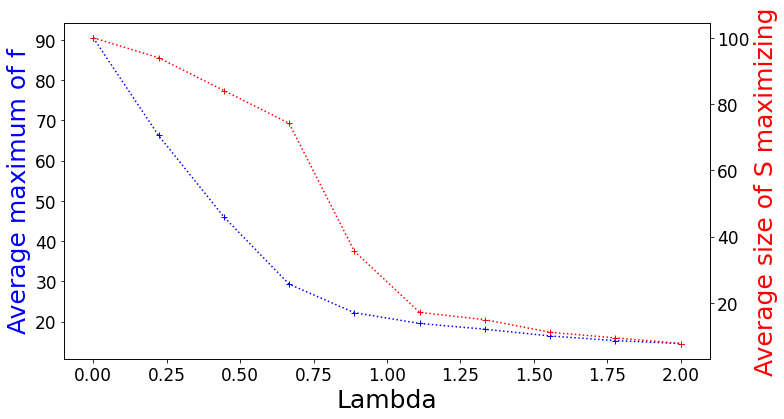

In [13]:
G = G2
nb_instances = 10
lambdas = np.linspace(0, 2, 10)

plot_avg_lambda(G, lambdas, betas, n_iter, nb_instances, verbose=False)